In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import math


# Bayes Risk Functions


In [144]:

class BayesRisk():
    def __init__(self, x, N, P):
        self.x = x
        self.N = N
        self.P = P
        self.likelihood = self.norm_distribution()
        self.likelihood_ratio = self.likelihood[0]/self.likelihood[1]
        self.prior = self.prior_probability()
        self.evidence = self.evidence_distribution()
        self.posterior = self.posterior_probability()

    def plot_data(self, data_vector,  title="", n_classes=2, xlim=(-10, 10), ylim=(0, 0.5), legends=[]):

        _, ax = plt.subplots()

        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

        ax.set_title(title)
        ax.set_xlabel('x')
        ax.set_ylabel('Probability, P')

        # print(len(data_vector))
        if len(data_vector) > n_classes:
            data_vector = [data_vector]

        for idx, d in enumerate(data_vector):
            label = legends[idx] if legends else f"Class {idx + 1}"
            ax.plot(self.x, d, label=label)

        if legends:
            ax.legend()

        plt.show()

    def norm_distribution(self):
        '''Given mean and standard deviation, outputs the normal distribution for x,
        which can be a vector or a specific value.'''

        # return partial dist. vector from N(mu, std. dev.)
        return np.array([stats.norm(mu, np.sqrt(sigma)).pdf(self.x) for mu, sigma in self.N])

    def prior_probability(self):
        return np.array([likelihood*prior for likelihood, prior in zip(self.likelihood, self.P)])

    def evidence_distribution(self):
        return sum(self.prior, 0)

    def posterior_probability(self):
        return np.array([p/ev for p, ev in zip(self.prior, self.evidence)])
        # return self.prior/self.evidence

    def zero_one_loss(self, risk_matrix):
        theta_zero_one = self.P[1]/self.P[0]
        return (risk_matrix[0][1] - risk_matrix[1][1])/(risk_matrix[1][0] - risk_matrix[0][0])*theta_zero_one

    def bayes_risk_df(self, risk_matrix):
        '''Calculate the likelihood ratio threshold for zero-one loss function, i.e. maximum posterior classification.'''

        data = {}
        for idx, risk in enumerate(risk_matrix):
            R = np.sum([a*b for a,b in zip(br.posterior, risk)], 0)
            data[f"Class {idx+1}"] = R

        return pd.DataFrame(data, index=x)

    def plot_bayes_risk_threshold(self, risk_matrix, legends=[], title="Bayes Conditional Risk, R(αi|x)"):
        """sketch the Bayes risk (conditional risk R(αi|x) associated with the action αi
        according to observation x) as a function of x"""


        risk_threshold = self.zero_one_loss(risk_matrix)
        df = self.bayes_risk_df(risk_matrix)
        df.plot()

        plt.title(title)
        plt.xlabel('x')
        plt.ylabel('R(αi|x)')

        if not legends:
            legends = df.columns

        plt.fill_between(self.x, df[legends[0]], where=(x < risk_threshold))
        plt.fill_between(self.x, df[legends[1]], where=(x > risk_threshold))

        plt.legend(legends)
        plt.show()



## Example

For a one dimensional 2-class problem with 2 actions a1, a2 (a1: choose ω1; a2 choose ω2),  
where N(µ, σ^2) is Normal distribution, and µ is mean and σ^2 is variance, given:
- prior probability: P(ω1) = 3/5, P(ω2) = 2/5
- class conditional densities: p(x|ω1) ~ N(0, 1) and p(x|ω2) ~ N(2, 4)  


If x = 5.0:

Class likelihood:
Class 1, N(0, 1) = 1.49e-06
Class 2, N(2, 4) = 6.48e-02

Likelihood ratio = 2.30e-05

Evidence = 2.59e-02

Class posterior probability:
Class 1, N(0, 1) = 3.4e-05

Total risk = 8e+07



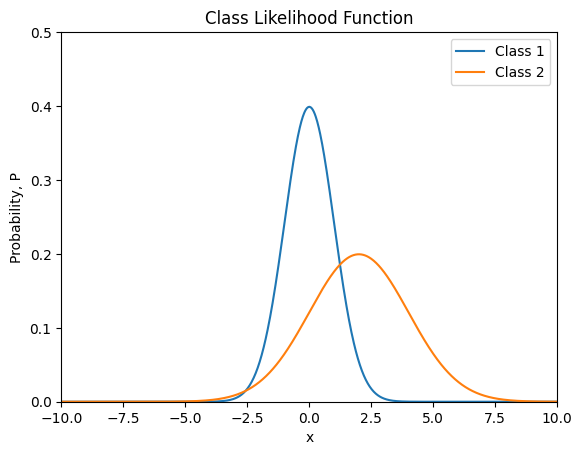

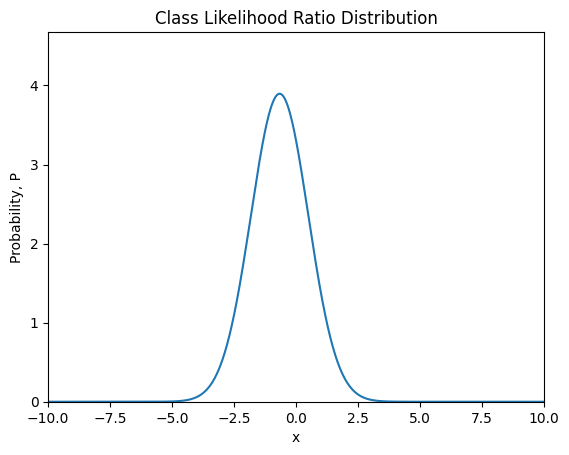

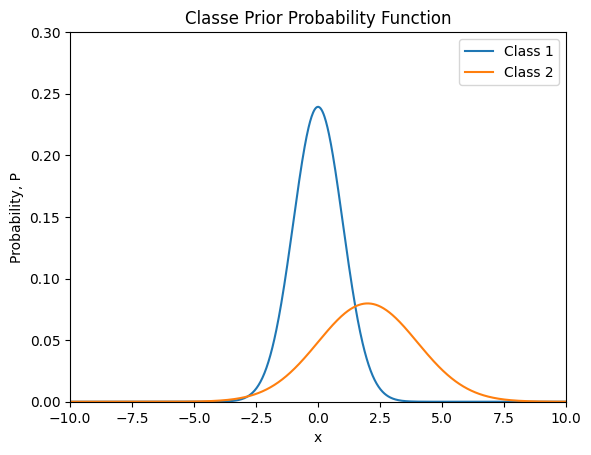

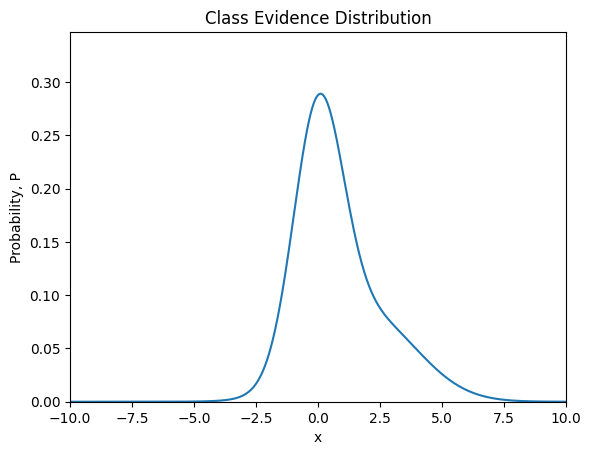

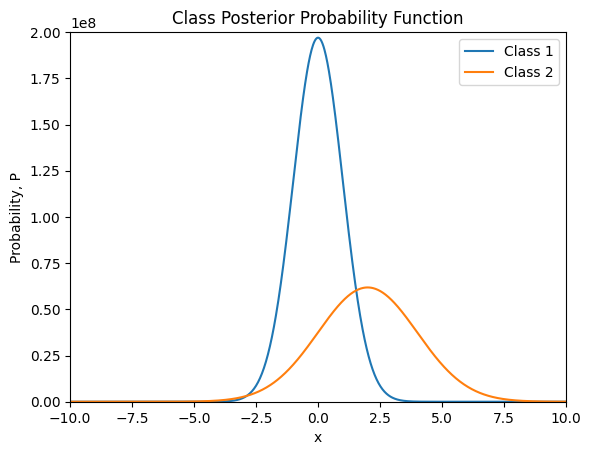

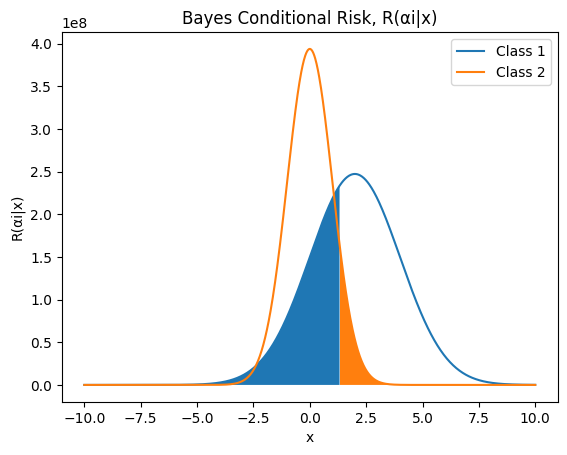

In [147]:

legends = ["Class 1", "Class 2"]
x = np.linspace(-10, 10, 1001)
P = [3/5, 2/5]                          # prior probabilities
N = [(0, 1), (2, 4)]                    # class conditional densities
risk_matrix = [[0,4],                   # example 2x2 risk matrix
               [2,0]]

## all classes ##
# init bayes risk obj
br = BayesRisk(x, N, P)
df = br.bayes_risk_df(risk_matrix)

## single point ##
x_i = 5.0
br_point = BayesRisk([x_i], N, P)

print(f"\nIf x = {x_i}:")

print(f'\nClass likelihood:')
for i, likelihood in enumerate(br_point.likelihood):
    print(f'Class {i+1}, N{N[i]} = {likelihood[0]:.2e}')

print(f'\nLikelihood ratio = {br_point.likelihood_ratio[0]:.2e}')

print(f'\nEvidence = {br_point.evidence[0]:.2e}')

print(f'\nClass posterior probability:')                            # TODO somethings up here
for i, posterior in enumerate(br_point.posterior):
    print(f'Class {i+1}, N{N[i]} = {posterior[0]:.2}')

print(f'\nTotal risk = {df.loc[x_i].sum():.2}\n')

# plot class likelihood, evidence distribution, and prior/posterior probability distributions
br.plot_data(br.likelihood, "Class Likelihood Function", ylim=(0, 0.5), legends=legends)
br.plot_data(br.likelihood_ratio, "Class Likelihood Ratio Distribution", ylim=(0, max(br.likelihood_ratio)*1.2))
br.plot_data(br.prior, "Classe Prior Probability Function", ylim=(0, 0.3), legends=legends)
br.plot_data(br.evidence, "Class Evidence Distribution", ylim=(0, max(br.evidence)*1.2))
br.plot_data(br.posterior, "Class Posterior Probability Function", ylim=(0, 2e8), legends=legends)
br.plot_bayes_risk_threshold(risk_matrix, legends=legends)





# Decision Boundaries

In [177]:

def plot_decision_boundary(mu, boundary_func, x=np.linspace(-6, 8, 400), y=np.linspace(-6, 8, 400)):

    # Create a grid of points
    X, Y = np.meshgrid(x, y)

    # Compute the function values
    Z = np.array([boundary_func(xi, yi) for xi, yi in zip(np.ravel(X), np.ravel(Y))])
    Z = Z.reshape(X.shape)

    ### Plotting
    plt.figure(figsize=(8, 6))
    plt.contour(X, Y, Z, levels=[0], colors='red', linestyles='dashed')
    plt.contourf(X, Y, Z, levels=[0, Z.max()], colors='blue', alpha=0.5)
    plt.contourf(X, Y, Z, levels=[Z.min(), 0], colors='orange', alpha=0.5)
    plt.scatter(*mu[0], color='blue', label='Class 1 Mean')
    plt.scatter(*mu[1], color='orange', label='Class 2 Mean')
    plt.title('Decision Boundary')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend()
    plt.grid(True)
    plt.show()


def decision_boundary(mu, sigma, P):
    sig_inv = [np.linalg.inv(s) for s in sigma]

    W = [-0.5 * s_inv for s_inv in sig_inv]
    w = [np.dot(s_inv, m) for s_inv, m in zip(sig_inv, mu)]
    w0 = [
        -0.5 * np.dot(np.dot(m.T, s_inv), m) - 0.5 * np.log(np.linalg.det(s)) + np.log(p)
        for m, s_inv, s, p in zip(mu, sig_inv, sigma, P)
    ]

    # Define the decision function g(x) = g1(x) - g2(x); when g1 = g2 --> g1-g2 = 0
    decision_function = lambda x1, x2: (
        np.dot(np.dot([x1, x2], W[0]), [x1, x2]) + np.dot(w[0], [x1, x2]) + w0[0] -
        (np.dot(np.dot([x1, x2], W[1]), [x1, x2]) + np.dot(w[1], [x1, x2]) + w0[1])
    )

    return decision_function

def bhattacharyya_error_bound(mu, sigma, P):

    avg_sigma = np.sum(sigma, axis=0)/2
    delta_mu = mu[1] - mu[0]
    # Calculate Bhattacharyya coefficients
    t1 = 1/8 * np.dot(np.dot(delta_mu.T, np.linalg.inv(avg_sigma)), delta_mu)
    t2 = 0.5 * np.log(np.linalg.det(avg_sigma) / np.sqrt(np.linalg.det(sigma[0]) * np.linalg.det(sigma[1])))

    return np.sqrt(P[0] * P[1]) * np.exp(-(t1 + t2))



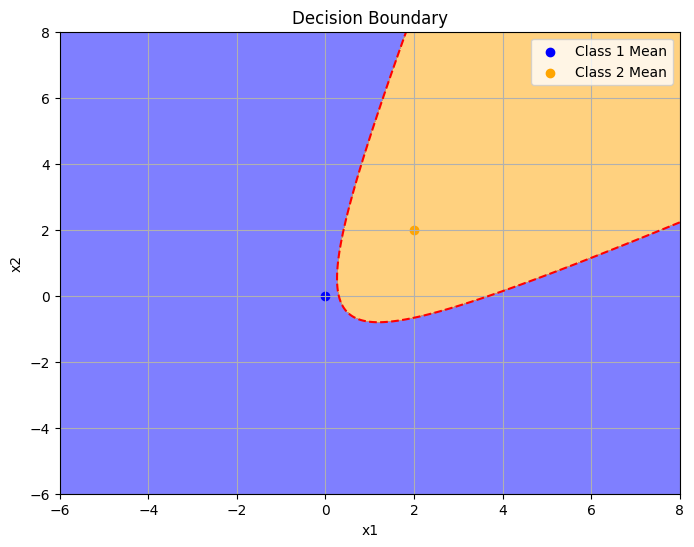


Bhattacharyya error bound: P(error) <= 0.2198


In [176]:

P = [0.25, 0.75]
mu = [np.array([0, 0]),
      np.array([2, 2])]
sigma = [np.array([[1, 0], [0, 2]]),
         np.array([[1, 1], [1, 2]])]

## decision boundary function ##
boundary_func = decision_boundary(mu, sigma, P)
plot_decision_boundary(mu, boundary_func)

## Bhattacharyya error bound ##
P_error = bhattacharyya_error_bound(mu, sigma, P)
print(f'\nBhattacharyya error bound: P(error) <= {P_error:.4f}')

